In [46]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector

In [47]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [48]:
pd.options.display.float_format = '{:,.4f}'.format

In [49]:
# !pip install pygam

# 0. Read Training Data

In [50]:
import xgboost  
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold

In [51]:
validation_data = pd.read_csv('validation_data.csv')

In [52]:
validation_data[validation_data['title_name'] == 'Wonder Woman 1984']

,Unnamed: 0,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,air_date,medal,episode_number_in_season,pillar_genre,is_pay_1,is_popcorn,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Adult Animation,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Kids/Family,genre_Music,genre_Other,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,genre_Unscripted,medal_number,is_new_content,age_of_content,hvr,ahvr,content_cost
1680,1680,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,60,"9,570,098.9560",1.1876,2020-12-25,2.4669,movies,acquired,2020-01-01,Platinum,nan,Action/Adventure,1,1,"200,000,000.0000",0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,1,0.9829,"3,879,333.6841",0.4814,"39,454,083.0000"


In [53]:
manual_pop_title = ['Euphoria', 'House of the Dragon', 'Peacemaker', 'The Last of Us']

In [54]:
validation_data.loc[validation_data['title_name'].isin(manual_pop_title), 'medal_number'] = 0
validation_data['hit_series'] = 0
validation_data.loc[validation_data['title_name'].isin(manual_pop_title), 'hit_series'] = 1

In [93]:
validation_data.head()

,Unnamed: 0,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,air_date,medal,episode_number_in_season,pillar_genre,is_pay_1,is_popcorn,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Adult Animation,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Kids/Family,genre_Music,genre_Other,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,genre_Unscripted,medal_number,is_new_content,age_of_content,hvr,ahvr,content_cost,hit_series
0,0,VICE Special Report: Killing Cancer,GV-54_wnG7qbCwwEAAAAY,0,60,17.0050,0.0000,2020-05-27,0.6400,movies,acquired,2015-01-01,None,nan,Documentary,0,0,nan,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,nan,0,5.4019,26.5703,0.0000,nan,0
1,1,VICE Special Report: Countdown to Zero,GV-55HghKlqbCwwEAAAAb,0,60,10.2350,0.0000,2020-05-27,0.8097,movies,acquired,2015-01-01,None,nan,Documentary,0,0,nan,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,nan,0,5.4019,12.6401,0.0000,nan,0
2,2,VICE Special Report: Fixing the System,GV-55Hwvj4IaDwwEAAAAY,0,60,46.8486,0.0000,2020-05-27,1.1081,movies,acquired,2015-01-01,None,nan,Documentary,0,0,nan,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,nan,0,5.4019,42.2800,0.0000,nan,0
3,3,VICE Special Report: Fighting ISIS,GV-55JASHjruwgwEAAAAU,0,60,57.6536,0.0000,2020-05-27,0.7864,movies,original,2016-01-31,None,nan,Documentary,0,0,nan,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,nan,0,4.3204,73.3145,0.0001,nan,0
4,4,Heartbreakers,GV-BGJA11hsLDwwEAAAAZ,0,60,"3,799.4667",0.0012,2020-09-01,2.0578,movies,acquired,2001-03-23,None,nan,Comedy,0,0,"35,000,000.0000",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,nan,0,19.4446,"1,846.3938",0.0006,"259,000.0000",0


# 1. Modeling - Cross Validation

In [55]:
META_COLS = ['title_name', 'title_id', 'season_number', 'offering_start_date', 'air_date','asset_run_time_hours',
            'content_category', 'program_type', 'medal', 'pillar_genre']

In [94]:
FEATURE_COLS = ['is_pay_1', 
#                 'is_popcorn', 
                'hit_series',
#                 'is_new_content', 
                'medal_number', 
#                 'age_of_content', 
#                 'content_cost', #XX
#                 'budget', 
#                 'content_category_livesports', 
                'content_category_movies', 
                'content_category_series', 
#                 'content_category_special', 
                'program_type_acquired', 
                'program_type_original', 
                'genre_Action/Adventure ', 
#                 'Dominant_Topic_7.0'    XX
#                 'genre_Classics',  
#                 'genre_Horror ',
                'genre_Comedy',
                'genre_Drama'
               ]

In [57]:
def cal_error(validation_set):
    error_col = ((validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]).abs()
    return error_col.mean()

## 1.3 Log AVHR

In [58]:
# !pip install pygam

#### 1.3.1 Significant title classifier

In [95]:
training_data = validation_data.copy()

In [96]:
training_data['is_significant_title'] = 1
training_data.loc[training_data['ahvr'] < 0.005, 'is_significant_title'] = 0

In [97]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)
## Checking if there are any nulls in the feature columns

is_pay_1                  0.0000
hit_series                0.0000
medal_number              0.9224
content_category_movies   0.0000
content_category_series   0.0000
program_type_acquired     0.0000
program_type_original     0.0000
genre_Action/Adventure    0.0000
genre_Comedy              0.0000
genre_Drama               0.0000
dtype: float64

In [98]:
training_data['medal_number'] = training_data['medal_number'].fillna(3)
training_data['content_cost'] = training_data['content_cost'].fillna(0)
training_data['age_of_content'] = training_data['age_of_content'].fillna(100)

In [99]:
TARGET_COL = ['is_significant_title']

In [100]:
from sklearn.linear_model import LogisticRegression

In [101]:
num_fold = 10
group_kfold = GroupKFold(n_splits=num_fold)

In [102]:
validation_set = pd.DataFrame()

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model|
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        clf = LogisticRegression(random_state=0).fit(X_train, y_train)
        pred = clf.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)
        print (clf.score(X_train, y_train))

    except Exception as e:
        print (e)
        raise 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8994899489948995
0.9014401440144014


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9045904590459046
0.9033903390339034


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9023402340234024
0.9024902490249025


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9020402040204021
0.9025048747562622


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9028048597570122
0.9020548972551372


In [67]:
validation_set.head()

,Unnamed: 0,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,air_date,medal,episode_number_in_season,pillar_genre,is_pay_1,is_popcorn,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Adult Animation,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Kids/Family,genre_Music,genre_Other,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,genre_Unscripted,medal_number,is_new_content,age_of_content,hvr,ahvr,content_cost,hit_series,is_significant_title,pred
0,3,VICE Special Report: Fighting ISIS,GV-55JASHjruwgwEAAAAU,0,60,57.6536,0.0000,2020-05-27,0.7864,movies,original,2016-01-31,None,nan,Documentary,0,0,nan,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3.0000,0,4.3204,73.3145,0.0001,0.0000,0,0,0
1,13,Race,GV-BPkgQsScLDwwEAAACE,0,60,"3,619.9519",0.0003,2022-11-01,2.2411,movies,acquired,2016-02-19,None,nan,Drama,0,0,"35,000,000.0000",0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.0000,0,6.6997,"1,615.2488",0.0001,"1,305,893.0000",0,0,0
2,29,Ghost in the Machine,GV1nlGAvbfbyvSwEAAAA4,0,60,979.1172,0.0001,2021-07-01,1.5883,movies,acquired,1993-12-29,None,nan,Horror,0,0,"12,000,000.0000",0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3.0000,0,27.5050,616.4433,0.0000,"349,333.0000",0,0,0
3,42,The Conspirator,GV40E6Qsrx7fDNQEAAAA-,0,60,"2,240.1247",0.0002,2021-11-01,1.9958,movies,acquired,2010-01-01,None,nan,Drama,0,0,"25,000,000.0000",0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.0000,0,11.8332,"1,122.4009",0.0001,"125,000.0000",0,0,0
4,66,Habla y vota,GV6zFJwLTMazCKQEAAAAc,0,60,12.6964,0.0000,2020-05-27,0.9183,movies,original,2016-09-16,None,nan,Other,0,0,nan,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.0000,0,3.6934,13.8255,0.0000,0.0000,0,0,0


#### 1.3.2 Modeling

In [103]:
training_data = validation_data[(validation_data['ahvr']>0.005)]
# training_data = validation_data[(validation_data['content_category'].isin(['movies', 'series', 'special']))]

In [104]:
len(training_data.title_id.unique())

704

In [105]:
from pygam import LinearGAM, s, PoissonGAM

In [123]:
FEATURE_COLS = ['is_pay_1', 
#                 'is_popcorn', 
                'hit_series',
#                 'is_new_content', 
                'medal_number', 
#                 'age_of_content', 
#                 'content_cost', #XX
#                 'budget', 
#                 'content_category_livesports', 
                'content_category_movies', 
                'content_category_series', 
#                 'content_category_special', 
                'program_type_acquired', 
                'program_type_original', 
                'genre_Action/Adventure ', 
#                 'Dominant_Topic_7.0'    XX
#                 'genre_Classics',  
#                 'genre_Horror ',
                'genre_Comedy',
                'genre_Drama'
               ]

In [124]:
training_data['log_ahvr'] = np.log2(training_data['ahvr'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [125]:
TARGET_COL = ['log_ahvr']

In [126]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)
## Checking if there are any nulls in the feature columns

is_pay_1                  0.0000
hit_series                0.0000
medal_number              0.0000
content_category_movies   0.0000
content_category_series   0.0000
program_type_acquired     0.0000
program_type_original     0.0000
genre_Action/Adventure    0.0000
genre_Comedy              0.0000
genre_Drama               0.0000
dtype: float64

In [127]:
training_data['medal_number'] = training_data['medal_number'].fillna(3)
training_data['content_cost'] = training_data['content_cost'].fillna(0)
training_data['age_of_content'] = training_data['age_of_content'].fillna(100)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [128]:
num_fold = 10
group_kfold = GroupKFold(n_splits=num_fold)

In [129]:
### DOWNSIDE --- DO NOT TAKE NULL ####
validation_set = pd.DataFrame()
# feature_importances = pd.DataFrame()
# gam = LinearGAM(s(0))

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model|
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        gam = LinearGAM(n_splines=20).fit(X_train, y_train)
        pred = gam.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

    except Exception as e:
        print (e)
        raise 

In [130]:
cal_error(validation_set) #0.3869481250303666

0.17047511566416926

In [131]:
validation_set = validation_set[META_COLS+FEATURE_COLS+['ahvr']+TARGET_COL+['pred']]

In [132]:
validation_set['pred_antilog'] = (2**(validation_set['pred']))

In [133]:
def cal_true_error(validation_set):
    error_col = (validation_set['pred_antilog']-validation_set['ahvr']).abs()/validation_set['ahvr']
    return error_col.mean()

In [134]:
cal_true_error(validation_set)

0.6592126725498673

In [135]:
validation_set['error'] = (validation_set['pred_antilog']-validation_set['ahvr'])
validation_set['pct_error'] = (validation_set['pred_antilog']-validation_set['ahvr'])/validation_set['ahvr']
validation_set['abs_pct_error'] = (validation_set['pred_antilog']-validation_set['ahvr']).abs()/validation_set['ahvr']

In [136]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [137]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.9784
Link Function:                     IdentityLink Log Likelihood:                                 -1274.4874
Number of Samples:                          861 AIC:                                             2574.9317
                                                AICc:                                              2575.36
                                                GCV:                                                1.1647
                                                Scale:                                              1.1355
                                                Pseudo R-Squared:                                   0.2724
Feature Function                  Lam

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  if __name__ == '__main__':


In [138]:
import matplotlib.pyplot as plt

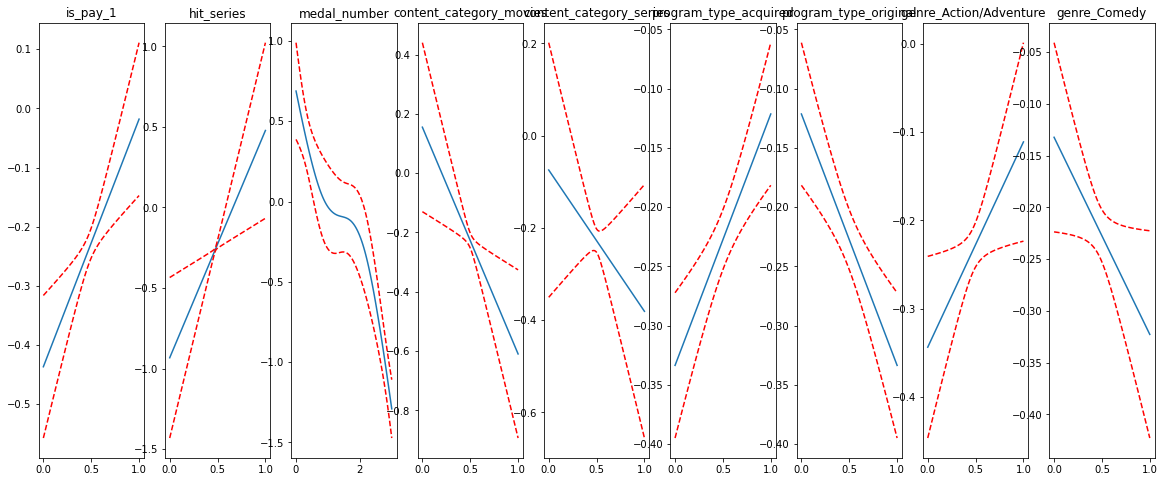

In [140]:
plt.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1, 9)
titles = FEATURE_COLS
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [88]:
validation_set.sort_values(by = ['error'])[['title_name', 'season_number', 'ahvr', 'pred_antilog', 'error']].head(15)

,title_name,season_number,ahvr,pred_antilog,error
26,Wonder Woman 1984,0,0.4814,0.0631,-0.4183
65,The Little Things,0,0.3071,0.0277,-0.2794
52,Scoob!,0,0.1588,0.0223,-0.1365
62,An American Pickle,0,0.1551,0.0191,-0.1360
81,Free Guy,0,0.1640,0.0403,-0.1236
21,The Undoing,1,0.1447,0.0245,-0.1203
46,Lovecraft Country,1,0.1344,0.0230,-0.1114
60,Birds of Prey: Harley Quinn,0,0.1484,0.0393,-0.1090
24,Roald Dahl’s The Witches,0,0.1358,0.0297,-0.1061
22,The Flight Attendant,1,0.1495,0.0439,-0.1056


In [89]:
validation_set[validation_set['title_name'] == 'The Last of Us']

,title_name,title_id,season_number,offering_start_date,air_date,asset_run_time_hours,content_category,program_type,medal,pillar_genre,is_pay_1,hit_series,medal_number,content_category_movies,content_category_series,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Classics,genre_Horror,ahvr,log_ahvr,pred,pred_antilog,error,pct_error,abs_pct_error
85,The Last of Us,GYyofRQHeuJ6fiQEAAAEy,1,2023-01-16,2023-03-12,8.6956,series,original,Platinum,Drama,0,1,0.0000,0,1,0,1,0,0,0,0.1425,-2.8107,-3.2958,0.1018,-0.0407,-0.2855,0.2855


In [90]:
validation_set['offering_start_date'] = pd.to_datetime(validation_set['offering_start_date'])

In [91]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

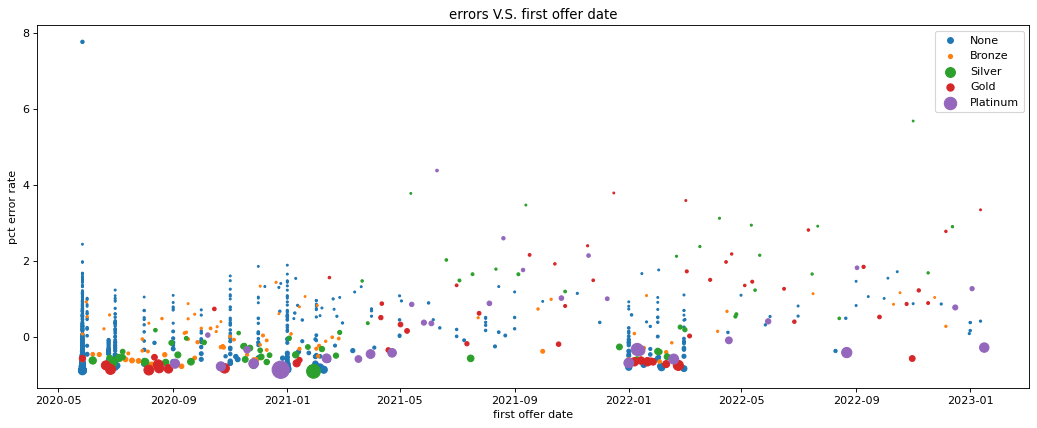

In [92]:
figure(figsize=(16, 6), dpi=80)
for c in validation_set.medal.unique():
    plot_data = validation_set[(validation_set['medal'] == c)]
    plt.scatter(plot_data['offering_start_date'], plot_data['pct_error'], label = c, s = plot_data['ahvr']*500)
plt.title('errors V.S. first offer date')
plt.xlabel('first offer date')
plt.ylabel('pct error rate')
plt.legend()
plt.show()

# Write to S3/SF

In [36]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [394]:
import boto3
import io

def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
output_bucket = 'hbo-outbound-datascience-content-dev'
s3 = boto3.resource('s3')
bucket = s3.Bucket(output_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    to_s3(filename, output_bucket, content)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [395]:
validation_set.columns

Index(['title_name', 'title_id', 'season_number', 'offering_start_date',
       'air_date', 'asset_run_time_hours', 'content_category', 'program_type',
       'medal', 'pillar_genre', 'is_pay_1', 'is_popcorn', 'hit_series',
       'medal_number', 'age_of_content', 'content_category_movies',
       'content_category_series', 'program_type_acquired',
       'program_type_original', 'genre_Action/Adventure ', 'genre_Classics',
       'genre_Horror ', 'ahvr', 'log_ahvr', 'pred', 'pred_antilog', 'error',
       'pct_error', 'abs_pct_error'],
      dtype='object')

In [396]:
FINAL_OUTPUT_COL = ['title_name', 'title_id', 'season_number', 'offering_start_date',
       'air_date', 'asset_run_time_hours', 'content_category', 'program_type',
       'medal', 'pillar_genre', 'is_pay_1', 'is_popcorn', 'medal_number',
       'age_of_content', 'average_hours_viewed', 'log_average_hours_viewed', 
        'pred_logged', 'prediction','pct_error']

In [397]:
validation_set.rename(columns = {'ahvr':'average_hours_viewed', 'log_ahvr':'log_average_hours_viewed', 
                                 'pred':'pred_logged', 'pred_antilog':'prediction'}, inplace = True)

In [398]:
validation_set[FINAL_OUTPUT_COL].to_csv('validation_set_prediction_model.csv')

In [399]:
filename = 'cross_validation_results_'+pd.Timestamp.today().strftime('%Y-%m-%d')

In [400]:
write_to_sf(validation_set[FINAL_OUTPUT_COL], filename)

In [401]:
validation_set[FINAL_OUTPUT_COL].head()

,title_name,title_id,season_number,offering_start_date,air_date,asset_run_time_hours,content_category,program_type,medal,pillar_genre,is_pay_1,is_popcorn,medal_number,age_of_content,average_hours_viewed,log_average_hours_viewed,pred_logged,prediction,pct_error
0,AVPR Aliens vs. Predator Requiem,GV-BGQgVr57OCwgEAAAAp,0,2020-09-01,2007-12-26,1.5633,movies,acquired,None,Action/Adventure,0,0,3.0000,12.6847,0.0074,-7.0858,-6.4386,0.0115,0.5661
1,Black Knight,GV1nk9wgLyKiBGAEAAAAj,0,2020-05-27,2001-11-21,1.5931,movies,acquired,None,Comedy,0,0,3.0000,18.5137,0.0062,-7.3257,-6.4949,0.0111,0.7787
2,Batman: The Killing Joke,GV_6BRg2w-LGXwwEAAABB,0,2020-05-27,2016-07-25,1.2767,movies,acquired,None,Action/Adventure,0,0,3.0000,3.8385,0.0084,-6.8998,-5.9531,0.0161,0.9275
3,Annabelle: Creation,GW6PBUwTgchjDwgEAAABe,0,2020-12-01,2017-08-11,1.7739,movies,acquired,None,Horror,0,0,3.0000,3.3074,0.0104,-6.5894,-6.4852,0.0112,0.0749
4,The Conjuring 2,GWPUpFw5gVrCtkwEAAABv,0,2020-05-27,2016-06-10,2.2306,movies,acquired,None,Horror,0,0,3.0000,3.9618,0.0094,-6.7260,-6.4979,0.0111,0.1712


In [84]:
run_query('''
create or replace table max_dev.workspace.user_title_hours_watched_crossvalidation 
(
title_name	VARCHAR,
title_id	VARCHAR,
season_number	int,
offering_start_date	VARCHAR,
air_date	VARCHAR,
asset_run_time_hours	float,
content_category	VARCHAR,
program_type	VARCHAR,
medal	VARCHAR,
pillar_genre	VARCHAR,
is_pay_1	int,
is_popcorn	int,
medal_number	int,
age_of_content	float,
content_cost	bigint,
average_hours_viewed	float,
log_average_hours_viewed	float,
pred_logged	float,
prediction	float,
pct_error	float
);

''')

,status
0,Table USER_TITLE_HOURS_WATCHED_CROSSVALIDATION...


In [86]:
run_query('''
copy into max_dev.workspace.user_title_hours_watched_crossvalidation
    from(
        select
              $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11, $12,$13, $14, $15, $16, $17, $18, $19, $20
        from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/title_hours_viewed_retention/cross_validation_results.csv
        )
    file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
    on_error = 'CONTINUE';

''')

,file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
0,s3://hbo-outbound-datascience-content-dev/titl...,LOADED,487,487,487,0,None,None,None,None


# OTHER MODELS

## 1.1 Random Forest CV

In [78]:
training_data = validation_data[(validation_data['ahvr']>0.005)]
# training_data = training_data[META_COLS+FEATURE_COLS+TARGET_COL]

In [79]:
# training_data = training_data.sort_values(by = ['offering_start_date']).reset_index(drop = True)

In [80]:
num_fold = 10
group_kfold = GroupKFold(n_splits=num_fold)

In [88]:
TARGET_COL = ['ahvr']

In [89]:
len(training_data)

861

In [90]:
validation_set = pd.DataFrame()
feature_importances = pd.DataFrame()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
    
#     offer_date = test_df['offering_start_date'].min()
#     train_df = train_df[train_df['offering_start_date']<=offer_date]
#     if offer_date == '2020-05-27':
#         print ('pass')
#         continue
    n_record = len(train_df.title_id.unique())
    print ("n of Validation Title: " + str(n_record))
    n_record = len(test_df.title_id.unique())
    print ("n of Test Title: " + str(n_record))
#     print (test_df.offering_start_date.unique())
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]
        
        

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

#         fi = model.feature_importances_
#         fi_df = pd.DataFrame([fi])
#         fi_df.columns = FEATURE_COLS
#         fi_df['match_id'] = test_df['match_id'].values[0]
#         fi_df['title_name'] = test_df['title_name'].values[0]
#         fi_df['days_on_hbo_max'] = day
#         feature_importances=pd.concat([feature_importances, fi_df], axis = 0)

#     except (KeyboardInterrupt, SystemExit):
#         raise

    except Exception as e: print(e)

n of Validation Title: 640
n of Test Title: 64
n of Validation Title: 634
n of Test Title: 70
n of Validation Title: 634
n of Test Title: 70
n of Validation Title: 634
n of Test Title: 70
n of Validation Title: 633
n of Test Title: 71
n of Validation Title: 633
n of Test Title: 71
n of Validation Title: 632
n of Test Title: 72
n of Validation Title: 632
n of Test Title: 72
n of Validation Title: 632
n of Test Title: 72
n of Validation Title: 632
n of Test Title: 72


In [91]:
cal_error(validation_set)

1.1114687082637646

In [92]:
validation_set['pct_error'] = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]

In [93]:
validation_set[validation_set['title_name']=='Wonder Woman 1984']

,Unnamed: 0,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,air_date,medal,episode_number_in_season,pillar_genre,is_pay_1,is_popcorn,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Adult Animation,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Kids/Family,genre_Music,genre_Other,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,genre_Unscripted,medal_number,is_new_content,age_of_content,hvr,ahvr,content_cost,pred,pct_error
26,1680,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,60,"9,570,098.9560",1.1876,2020-12-25,2.4669,movies,acquired,2020-01-01,Platinum,nan,Action/Adventure,1,1,"200,000,000.0000",0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,1,0.9829,"3,879,333.6841",0.4814,"39,454,083.0000",0.1143,0.7625


In [141]:
validation_set[validation_set['pct_error']>2]

,title_name,title_id,season_number,offering_start_date,asset_run_time_hours,is_pay_1,is_popcorn,is_new_content,medal_number,age_of_content,content_cost,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,Dominant_Topic_7.0,ahvr,group_num,pred,pct_error
1,South Park,GXr7SEgRi2sLCAAEAAAQu,1,2020-06-24,4.7847,0,0,0,nan,22.4782,"416,645,951.0000","300,000.0000",0,0,1,0,1,0,0,0,0.0537,3.0000,0.2013,2.7487
2,South Park,GXr7SEgRi2sLCAAEAAAQu,4,2020-06-24,6.2522,0,0,0,nan,20.4795,nan,nan,0,0,1,0,1,0,0,0,0.0516,3.0000,0.2036,2.9430
11,South Park,GXr7SEgRi2sLCAAEAAAQu,15,2020-06-24,5.1492,0,0,0,nan,9.4786,nan,nan,0,0,1,0,1,0,0,0,0.0651,3.0000,0.1952,2.0004
21,It,GWt7vKAJzFri8vQEAAAKm,0,2020-10-27,2.1964,0,0,0,nan,3.8194,"9,029,193.0000","35,000,000.0000",0,1,0,0,1,0,0,1,0.0585,5.0000,0.1884,2.2182
26,Reminiscence,GYQBEaQwta8PCAAEAAAA-,0,2021-08-20,1.8928,1,1,1,0.0000,0.0000,"12,050,725.0000","54,000,000.0000",0,1,0,0,1,0,0,0,0.0519,7.0000,0.1697,2.2692
17,A West Wing Special to Benefit When We All Vote,GX4YOrQsIwGNViQEAAAGH,0,2020-10-15,1.0647,0,0,1,1.0000,0.0000,"9,000,000.0000",nan,0,0,0,1,0,1,0,0,0.0612,5.0000,0.2003,2.2747
23,THE NEVERS,GYBllVQbyTkOLlAEAAAAC,1,2021-04-12,5.8469,0,0,1,1.0000,-0.0931,"233,600,000.0000",nan,0,0,1,0,1,0,0,1,0.0605,7.0000,0.1946,2.2149
31,Westworld,GV7xwpQNK8MJfPwEAAAG_,4,2022-06-27,7.2222,0,0,1,1.0000,-0.1314,"222,600,000.0000",nan,0,0,1,0,0,1,0,0,0.0538,9.0000,0.1754,2.2608
4,The Fresh Prince of Bel-Air,GXdLWQgqPHKXCPQEAAAxk,5,2020-05-27,9.1800,0,0,0,nan,25.4023,nan,nan,0,0,1,0,1,0,0,0,0.0501,1.0000,0.1503,2.0026
10,Transformers: Revenge of the Fallen,GXrRoWwrze8JwwwEAAAAR,0,2020-05-27,2.4969,0,0,0,nan,11.4006,nan,"200,000,000.0000",0,1,0,0,1,0,1,0,0.0571,1.0000,0.1781,2.1182


## 1.2 Bayesian Regression CV

In [17]:
# !pip install pygam

In [18]:
from pygam import LinearGAM, s

In [21]:
training_data = validation_data#[(validation_data['ahvr'] > 0.03)]
# training_data = training_data[META_COLS+FEATURE_COLS+TARGET_COL]

In [22]:
len(training_data.title_id.unique())

6145

In [7]:
META_COLS = ['title_name', 'title_id', 'season_number', 'offering_start_date', 'air_date','asset_run_time_hours',
            'content_category', 'program_type', 'medal', 'pillar_genre']

In [25]:
FEATURE_COLS = ['is_pay_1', 
                'is_popcorn', 
#                 'is_new_content', 
                'medal_number', 
                'age_of_content', 
#                 'content_cost', #XX
                'budget', 
#                 'content_category_livesports', 
                'content_category_movies', 
                'content_category_series', 
#                 'content_category_special', 
                'program_type_acquired', 
                'program_type_original', 
                'genre_Action/Adventure ', 
#                 'Dominant_Topic_7.0'    XX
                'genre_Classics',  
                'genre_Horror '
               ]

In [9]:
TARGET_COL = ['ahvr'] # cumulative_first_views

In [26]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)

is_pay_1                  0.0000
is_popcorn                0.0000
medal_number              0.9225
age_of_content            0.0020
budget                    0.6110
content_category_movies   0.0000
content_category_series   0.0000
program_type_acquired     0.0000
program_type_original     0.0000
genre_Action/Adventure    0.0000
genre_Classics            0.0000
genre_Horror              0.0000
dtype: float64

In [24]:
training_data.sort_values(by = ['offering_start_date'], inplace = True)

In [28]:
training_data['medal_number'] = training_data['medal_number'].fillna(3)
# training_data['content_cost'] = training_data['content_cost'].fillna(0)
training_data['budget'] = training_data['budget'].fillna(0)
training_data['age_of_content'] = training_data['age_of_content'].fillna(100)

In [29]:
### DOWNSIDE --- DO NOT TAKE NULL ####
validation_set = pd.DataFrame()
# feature_importances = pd.DataFrame()
# gam = LinearGAM(s(0))

for train_index, test_index in group_kfold.split(training_data, groups=training_data['offering_start_date'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        gam = LinearGAM(n_splines=10).fit(X_train, y_train)
        pred = gam.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

    except Exception as e:
        print (e)
        raise 

In [30]:
cal_error(validation_set)

75.62843424120426

In [31]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [32]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     25.7703
Link Function:                     IdentityLink Log Likelihood:                             -34959238.1673
Number of Samples:                         7407 AIC:                                         69918529.8753
                                                AICc:                                        69918530.0768
                                                GCV:                                                0.0001
                                                Scale:                                              0.0001
                                                Pseudo R-Squared:                                   0.3865
Feature Function                  Lam

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  if __name__ == '__main__':


In [33]:
import matplotlib.pyplot as plt

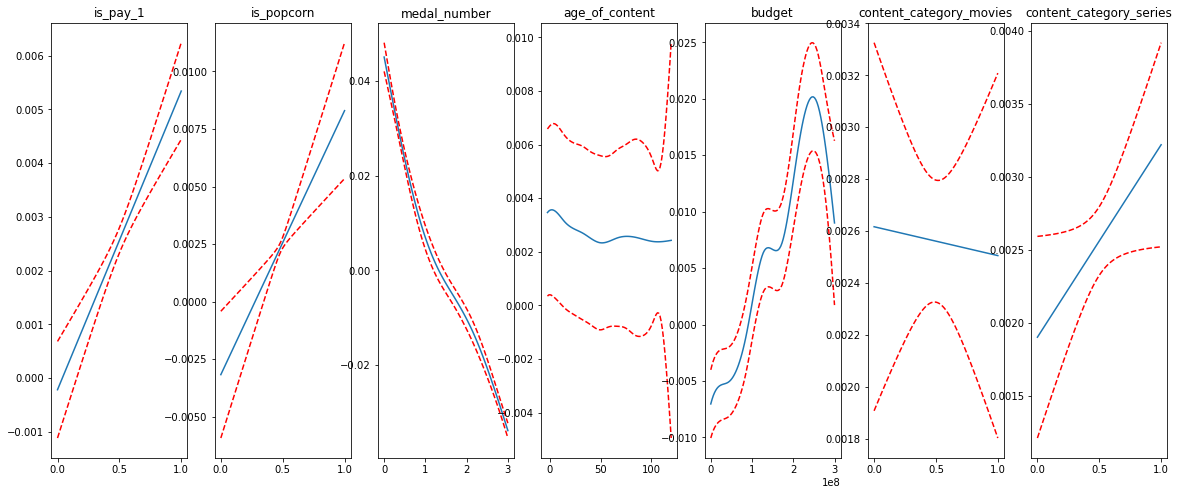

In [34]:
plt.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1, 7)
titles = FEATURE_COLS
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [364]:
validation_set = validation_set[META_COLS+FEATURE_COLS+TARGET_COL+['pred']]

In [365]:
validation_set['pct_error'] = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]

In [366]:
validation_set[validation_set['title_name']=='House of the Dragon']

,title_name,title_id,season_number,offering_start_date,asset_run_time_hours,is_pay_1,is_popcorn,medal_number,age_of_content,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,genre_Action/Adventure,ahvr,pred,pct_error
39,House of the Dragon,GYsYeoAxKH8LCwgEAAAOR,1,2022-08-22,10.2592,0,0,0.0000,-0.1698,0.0000,0,0,1,0,0,0.5004,0.3849,0.2308


In [357]:
validation_set[validation_set['pct_error']>2]

,title_name,title_id,season_number,offering_start_date,asset_run_time_hours,is_pay_1,is_popcorn,medal_number,age_of_content,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,genre_Action/Adventure,ahvr,pred,pct_error
0,Cast Away,GV7tyCwdtM8MbwgEAAAAi,0,2020-05-27,2.3492,0,0,4.0000,8.7284,"90,000,000.0000",0,1,0,0,1,0.0382,0.1543,3.0401
25,The Predator,GXILenABPPL2DVwEAAACA,0,2020-05-27,1.7850,1,0,4.0000,1.7002,"88,000,000.0000",0,1,0,0,1,0.0373,0.1398,2.7425
32,Rio,GXRtqyQJVuJVLqQEAAAC7,0,2020-05-27,1.5983,0,0,4.0000,9.1172,"90,000,000.0000",0,1,0,0,0,0.0339,0.1040,2.0662
33,Quantum of Solace,GXSybfg37fJVLqQEAAATy,0,2020-05-27,1.7331,0,0,4.0000,11.5321,"200,000,000.0000",0,1,0,0,1,0.0333,0.1041,2.1252
40,Green Lantern,GXXAljgW4WcPCwgEAAAHP,0,2020-05-27,1.9156,0,0,4.0000,8.9447,"200,000,000.0000",0,1,0,0,1,0.0314,0.1269,3.0481
84,Batman: The Dark Knight Returns Part 1,GXdu2UQBElaXCPQEAADfM,0,2020-05-27,1.2450,0,0,4.0000,8.4026,"3,500,000.0000",0,1,0,0,1,0.0349,0.1170,2.3492
92,Cowboys & Aliens,GXfuVnwyAm0ytlAEAABQJ,0,2020-05-27,1.9681,0,0,4.0000,8.8298,"163,000,000.0000",0,1,0,0,1,0.0313,0.1410,3.5023
109,Batman v Superman: Dawn of Justice,GXnEEqw6PJp4_wwEAAEv1,0,2020-05-27,2.5267,0,0,4.0000,4.1726,"250,000,000.0000",0,1,0,0,1,0.0401,0.1478,2.6903
122,The Boondocks,GXrMEtQ8sromBSgEAAAK1,4,2020-05-27,3.7553,0,0,4.0000,6.4012,0.0000,0,0,1,0,0,0.0318,0.1076,2.3823
33,THE NEVERS,GYBllVQbyTkOLlAEAAAAC,1,2021-04-12,5.8469,0,0,1.0000,-0.0931,0.0000,0,0,1,0,0,0.0605,0.1846,2.0494


## 1.4 Scale AVHR and Feature

In [18]:
# !pip install pygam

In [26]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer()

In [92]:
training_data = validation_data[(validation_data['ahvr']>0.03)]

In [93]:
len(training_data.title_id.unique())

398

In [94]:
from pygam import LinearGAM, s, PoissonGAM

In [95]:
training_data['quantile_ahvr'] = scaler.fit_transform(training_data['ahvr'].values.reshape(-1, 1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [96]:
TARGET_COL = ['quantile_ahvr']

In [97]:
FEATURE_COLS = ['is_pay_1', 
                'is_popcorn', 
#                 'is_new_content', 
                'medal_number', 
                'age_of_content', 
                'content_cost', #XX
#                 'budget', 
#                 'content_category_livesports', 
                'content_category_movies', 
                'content_category_series', 
#                 'content_category_special', 
                'program_type_acquired', 
                'program_type_original', 
                'genre_Action/Adventure ', 
#                 'Dominant_Topic_7.0'    XX
                'genre_Classics',  
                'genre_Horror '
               ]

In [98]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)
## Checking if there are any nulls in the feature columns

is_pay_1                  0.0000
is_popcorn                0.0000
medal_number              0.0000
age_of_content            0.0000
content_cost              0.0000
content_category_movies   0.0000
content_category_series   0.0000
program_type_acquired     0.0000
program_type_original     0.0000
genre_Action/Adventure    0.0000
genre_Classics            0.0000
genre_Horror              0.0000
dtype: float64

In [99]:
# training_data['content_cost_scaled'] = scaler.fit_transform(training_data['content_cost'].values.reshape(-1, 1))

In [100]:
training_data['medal_number'] = training_data['medal_number'].fillna(4)
training_data['content_cost'] = training_data['content_cost'].fillna(0)
training_data['age_of_content'] = training_data['age_of_content'].fillna(0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [101]:
num_fold = 10
group_kfold = GroupKFold(n_splits=num_fold)

In [102]:
### DOWNSIDE --- DO NOT TAKE NULL ####
validation_set = pd.DataFrame()
# feature_importances = pd.DataFrame()
# gam = LinearGAM(s(0))

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model|
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        gam = LinearGAM(n_splines=10).fit(X_train, y_train)
        pred = gam.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

    except Exception as e:
        print (e)
        raise 

In [103]:
cal_error(validation_set) #

inf

In [104]:
validation_set = validation_set[META_COLS+FEATURE_COLS+['ahvr']+TARGET_COL+['pred']]

In [105]:
validation_set['pred_transform'] = scaler.transform(validation_set['pred'].values.reshape(-1, 1))

In [106]:
def cal_true_error(validation_set):
    error_col = (validation_set['pred_transform']-validation_set['ahvr']).abs()/validation_set['ahvr']
    return error_col.mean()

In [107]:
cal_true_error(validation_set)

0.9211277147306077

In [108]:
validation_set['pct_error'] = (validation_set['pred_transform']-validation_set['ahvr']).abs()/validation_set['ahvr']

In [109]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [110]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      20.236
Link Function:                     IdentityLink Log Likelihood:                                -35093.6486
Number of Samples:                          487 AIC:                                            70229.7692
                                                AICc:                                           70231.8012
                                                GCV:                                                0.0068
                                                Scale:                                              0.0063
                                                Pseudo R-Squared:                                   0.2623
Feature Function                  Lam

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  if __name__ == '__main__':


In [111]:
import matplotlib.pyplot as plt

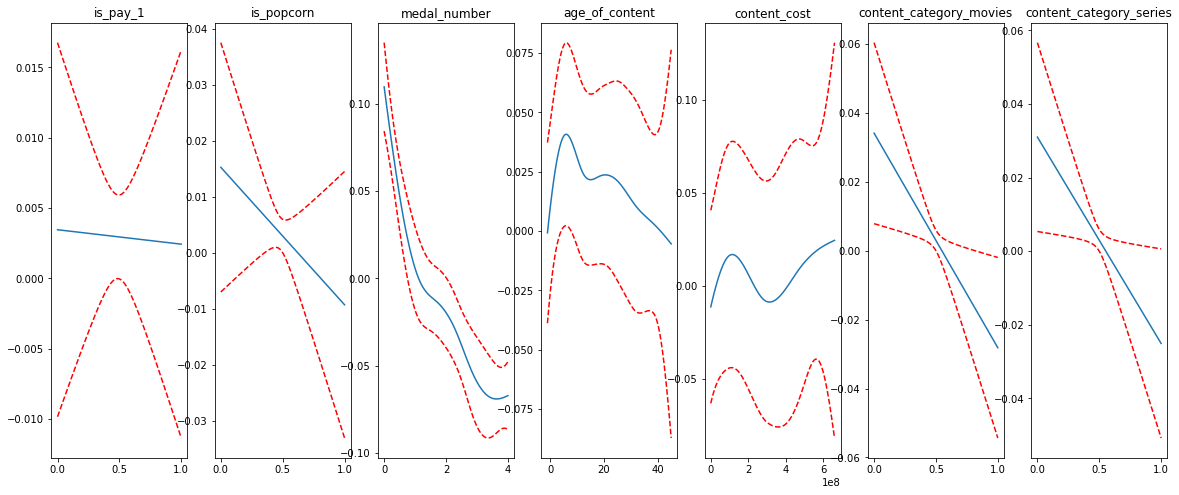

In [112]:
plt.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1, 7)
titles = FEATURE_COLS
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [113]:
validation_set.head()

,title_name,title_id,season_number,offering_start_date,air_date,asset_run_time_hours,content_category,program_type,medal,pillar_genre,is_pay_1,is_popcorn,medal_number,age_of_content,content_cost,content_category_movies,content_category_series,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Classics,genre_Horror,ahvr,quantile_ahvr,pred,pred_transform,pct_error
0,It,GWt7vKAJzFri8vQEAAAKm,0,2020-10-27,2017-01-01,2.1964,movies,acquired,None,Horror,0,0,4.0000,3.8194,"9,029,193.0000",1,0,1,0,0,0,1,0.0585,0.0161,0.0170,-0.0073,1.1250
1,Snow White and the Huntsman,GX42eRA3gLmNViQEAAAYP,0,2020-12-01,2012-06-01,2.0739,movies,acquired,None,Action/Adventure,0,0,4.0000,8.5012,"3,646,400.0000",1,0,1,0,1,0,0,0.0484,0.0104,0.0560,0.0146,0.6977
2,The Bee Gees: How Can You Mend A Broken Heart,GX5lfBgOJ7RKRwgEAAAMG,0,2020-12-13,2020-12-12,1.8503,movies,original,Silver,Documentary,0,0,2.0000,0.0027,"4,500,000.0000",1,0,0,1,0,0,0,0.1034,0.0414,0.0447,0.0083,0.9201
3,Deathstroke: Knights & Dragons,GX9jvbw7CW3idqQEAAABV,0,2021-01-01,2020-08-18,1.4161,movies,acquired,None,Action/Adventure,0,0,4.0000,0.3724,"1,080,000.0000",1,0,1,0,1,0,0,0.0330,0.0017,0.0283,-0.0010,1.0299
4,Chernobyl,GXJvkMAU0JIG6gAEAAAIo,1,2020-05-27,2019-06-03,5.2950,series,original,None,Drama,0,0,4.0000,0.9829,"16,200,000.0000",0,1,0,1,0,0,0,0.0394,0.0053,0.0213,-0.0049,1.1244


# 